In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ecdf
import time

# Generate data

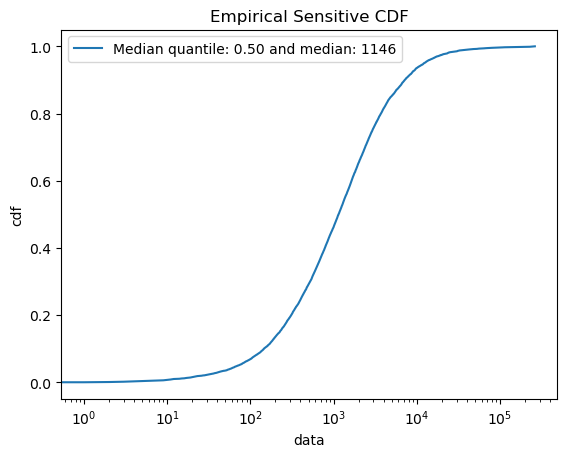

In [3]:
def generate_pareto_data(shape, N, scale=2000):
    D = np.random.pareto(shape, N) * scale
    return D


N = 10000  # number of samples

# generate the data
data = generate_pareto_data(1.5, N)

# discretize the data
num_bins = int(4 ** 9)  # Number of bins
bins = np.array(range(num_bins))  # Bin edges
intervals = np.array([bins[:-1], bins[1:]]).T
data = np.round(data).astype(int)  # integer data
data = np.clip(data, 0, num_bins - 1)

# get the empirical cdf of the coins
cf = ecdf(data)
cf_dict = dict(zip(cf.cdf.quantiles, cf.cdf.probabilities))

# get the median quantile
median = None
for i, j in enumerate(cf_dict.keys()):
    if cf_dict[j] > 0.5:
        median = int(list(cf_dict.keys())[i-1])
        break
median_quantile = cf_dict[median]

# plot cdf
plt.plot(cf.cdf.quantiles, cf.cdf.probabilities, label=f"Median quantile: {median_quantile:.2f} and median: {median}")
plt.xlabel("data")
plt.xscale("log")
plt.ylabel("cdf")
plt.title("Empirical Sensitive CDF")
plt.legend()
plt.show()

# Mechanism

In [4]:
from hierarchical_mechanism.mechanism import hierarchical_mechanism_quantile
from hierarchical_mechanism.data_structure import Tree

In [5]:
start = time.time()
tree = Tree(bins, branching=4)
print(f"Tree construction time: {time.time() - start:.2f} seconds")

Tree construction time: 4.82 seconds


In [9]:
eps = 8
replacement = False
target = 0.5
start = time.time()
dp_median = hierarchical_mechanism_quantile(tree=tree, 
                                            data=data,
                                            protocol="unary_encoding",
                                            eps=eps, 
                                            target=target, 
                                            replacement=replacement)
print(f"Hierarchical mechanism time: {time.time() - start:.2f} seconds")

Hierarchical mechanism time: 10.04 seconds


# Error

In [10]:
dp_median_quantile = None
if dp_median in cf_dict.keys():
    dp_median_quantile = cf_dict[dp_median]
else:
    for quantile in reversed(range(dp_median)):
        if quantile in cf_dict.keys():
            dp_median_quantile = cf_dict[quantile]
            break
error = dp_median_quantile - median_quantile

# Tree cdf

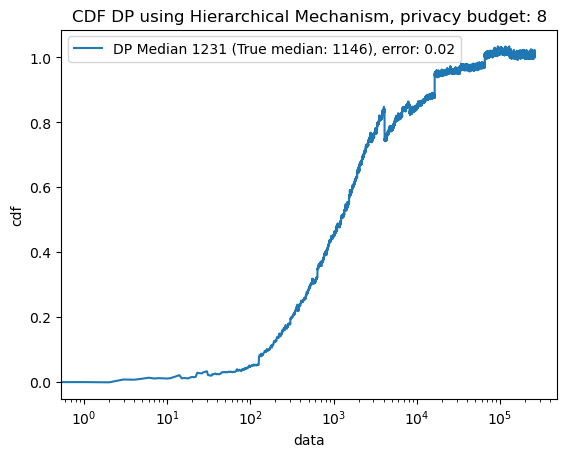

In [11]:
cdf_dp = tree.cdf
# plot cdf
plt.plot(cdf_dp, label=f"DP Median {dp_median} (True median: {median}), error: {error:.2f}")
plt.xlabel("data")
plt.xscale("log")
plt.ylabel("cdf")
plt.title(f"CDF DP using Hierarchical Mechanism, privacy budget: {eps}")
plt.legend()
plt.show()